In [1]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from scipy.spatial.distance import pdist, squareform
from libpysal.weights import DistanceBand, lag_spatial
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
import numpy as np

# Load crop production data
crop_df = pd.read_csv('Crop_Production_data.csv')

# ['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area', 'Production']

# Basic checks
print(f"Time range: {crop_df.Crop_Year.min()} - {crop_df.Crop_Year.max()}")
print(f"Districts: {crop_df.District_Name.nunique()}")
print(f"Missing values: \n {crop_df.isnull().sum()}")

Time range: 1997 - 2015
Districts: 644
Missing values: 
 State_Name          0
District_Name       0
Crop_Year           0
Season              0
Crop                0
Area                0
Production       3730
dtype: int64


In [2]:
# Load India districts shapefile (district boundries files)
gdf = gpd.read_file("IND_adm\IND_adm2.shp") 
states_gdf = gpd.read_file("IND_adm\IND_adm1.shp")

# function to Clean names in both the datasets and shap file
def clean_names(df, col):
    return df[col].str.strip().str.title()


# Modify the name of the districts from csv which won't match with shp file at all:
crop_df['State_Name'] = crop_df['State_Name'].replace('Uttarakhand','Uttaranchal')
crop_df['State_Name'] = crop_df['State_Name'].replace('Odisha','Orissa')
crop_df['District_Name'] = crop_df['District_Name'].replace('Y.S.R.','Cuddapah')
crop_df['District_Name'] = crop_df['District_Name'].replace('Purba Medinipur','East Midnapore')
crop_df['District_Name'] = crop_df['District_Name'].replace('Pashchim Medinipur','West Midnapore')
crop_df["District_Name"] = crop_df["District_Name"].replace('Bangalore', 'Bangalore URBAN')

# Clean the naming :
crop_df['State_Name'] = clean_names(crop_df, 'State_Name')
crop_df['District_Name'] = clean_names(crop_df, 'District_Name')
gdf['STATE'] = clean_names(gdf, 'NAME_1')        
gdf['District'] = clean_names(gdf, 'NAME_2')  

#gdf.head()

# Statistical overview of the data
crop_df.describe(include='all')

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
count,246091,246091,246091.000000,246091,246091,2.460910e+05,2.423610e+05
unique,33,644,NaN,8,126,NaN,NaN
top,Uttar Pradesh,Bijapur,NaN,Kharif,Rice,NaN,NaN
freq,33306,945,NaN,93584,15104,NaN,NaN
mean,NaN,NaN,2005.643018,NaN,NaN,1.200282e+04,5.825034e+05
std,NaN,NaN,4.952164,NaN,NaN,5.052340e+04,1.706581e+07
min,NaN,NaN,1997.000000,NaN,NaN,4.000000e-02,0.000000e+00
25%,NaN,NaN,2002.000000,NaN,NaN,8.000000e+01,8.800000e+01
50%,NaN,NaN,2006.000000,NaN,NaN,5.820000e+02,7.290000e+02
75%,NaN,NaN,2010.000000,NaN,NaN,4.392000e+03,7.023000e+03


In [3]:
## District Name macthing with shp file and corrections:

# Ref: i) https://www.datacamp.com/tutorial/fuzzy-string-python
#      ii) https://pathindependence.wordpress.com/2015/10/31/tutorial-fuzzywuzzy-string-matching-in-python-improving-merge-accuracy-across-data-products-and-naming-conventions/

## Identify Mismatches in Shap file Naming:
# Get unique state-district pairs from both datasets
df_districts = crop_df.groupby(['State_Name', 'District_Name']).size().reset_index()
shp_districts = gdf.groupby(['STATE', 'District']).size().reset_index()

# Find mismatches
mismatches = []
for idx, row in df_districts.iterrows():
    state = row['State_Name']
    district = row['District_Name']
    
    # Get matching districts from shapefile for this state
    shp_districts_for_state = shp_districts[shp_districts['STATE'] == state]['District'].tolist()
    
    if district not in shp_districts_for_state:
        mismatches.append({
            'State': state,
            'CSV_District': district,
            'Shapefile_Districts': shp_districts_for_state
        })

## Fuzzy Match Correction Suggestions ::

# Generate correction map
correction_map = {}
print("Suggested Corrections:")
for mismatch in mismatches:
    state = mismatch['State']
    csv_district = mismatch['CSV_District']
    candidates = mismatch['Shapefile_Districts']
    
    if candidates:
        match, score = process.extractOne(csv_district, candidates)
        if score > 70:  # 85 was giving much more mismatch
            # Add to correction map
            if state not in correction_map:
                correction_map[state] = {}
            correction_map[state][csv_district] = match
            
            # Print Correction :
            #print(f"{state}:")
            #print(f"  '{csv_district}' → '{match}' (confidence: {score}%)")

# Print the generated correction map
#print("\n Auto  Correction Map:")
#print(correction_map)        

# Update the dataframe with corrections
crop_df['District_Name'] = crop_df.apply(
    lambda x: correction_map.get(x['State_Name'], {}).get(x['District_Name'], x['District_Name']), 
    axis=1
)


Suggested Corrections:


<Figure size 1000x800 with 0 Axes>

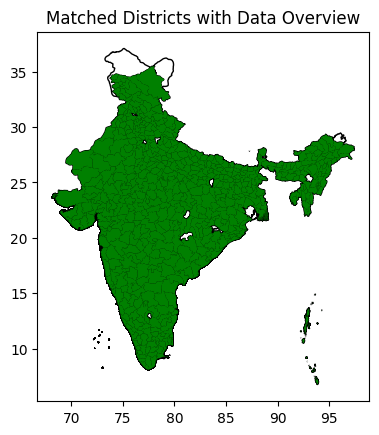

In [4]:
## Group District with state and distinct count to confirm mapping on shp file:

# Group districts with respective state to count the unique data point avialable:
district_counts = crop_df.groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
district_counts.columns = ['State_Name','District_Name','Count']

# SHAP file data naming change to all captial letter
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper()  # State column in shapefile

# CSV file data naming change to all captial letter
district_counts['State_Name'] = district_counts['State_Name'].str.upper()
district_counts['District_Name'] = district_counts['District_Name'].str.strip().str.upper()

# merge data {csv and shap}:
merged_data = pd.merge(gdf,district_counts,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)


# Copy District with no data
unmerge_struct = merged_data[merged_data['Count'].isna()]


# Drop the districts with no count/data available:
merged_data.dropna(subset=['Count'], inplace=True)

ax = plt.figure(figsize=(10, 8))

base = gdf.plot(color='white', edgecolor='black')
merged_data.plot(ax=base, color='green', markersize=0.1)

# Overlay state boundaries
#states_gdf.boundary.plot(ax=base, color='black', linewidth=1.2)

plt.title('Matched Districts with Data Overview')
plt.show()


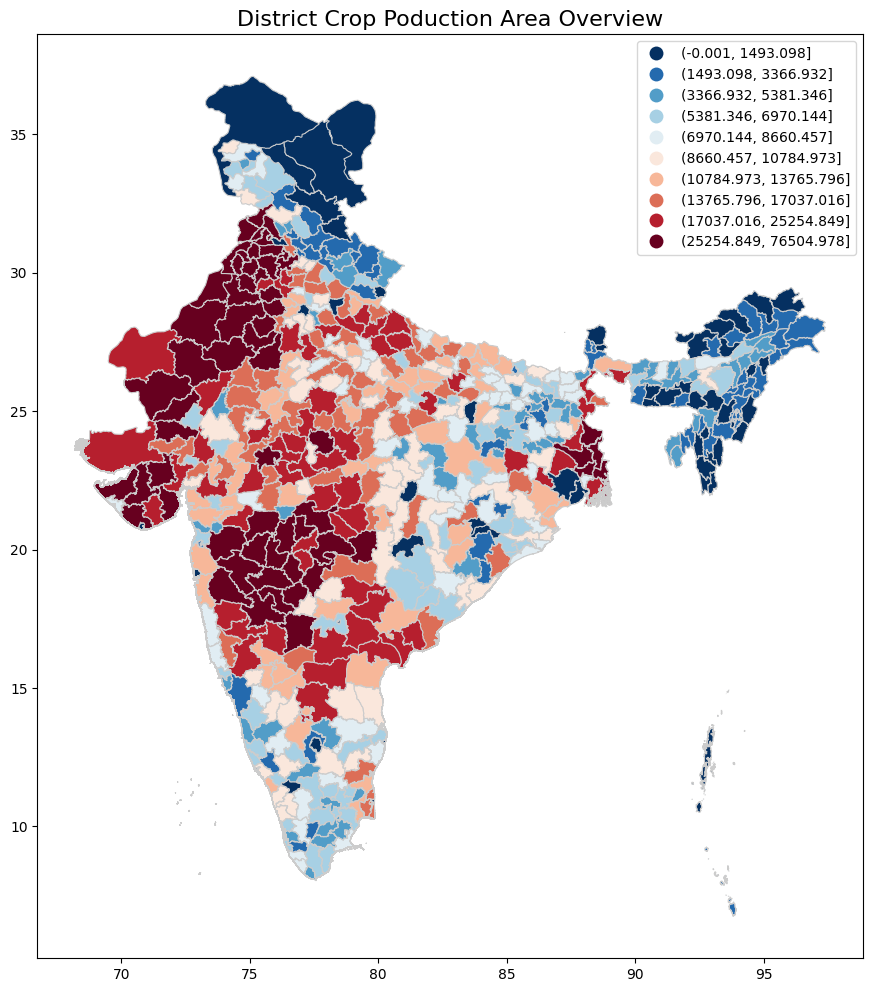

In [5]:
# Creating charts for Total production Area
# Aggregate data count/occurance by district (example for latest year)
latest_year = crop_df['Crop_Year'].max()
year = 2009

# Mean over all years and seasons production area for each district    
District_Area = crop_df.groupby(['State_Name','District_Name'])['Area'].mean().reset_index()
District_Area.columns = ['State_Name','District_Name','Area']

# Mean of specific year and seasons production area for each district:
# District_Area = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['Area'].mean().reset_index()
# District_Area.columns = ['State_Name','District_Name','Area']

# SHAP file State and district naming change to all captial letter:
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file State and district naming change to all captial letter:
District_Area['State_Name'] = District_Area['State_Name'].str.upper()
District_Area['District_Name'] = District_Area['District_Name'].str.strip().str.upper()

merged_data = pd.merge(gdf,District_Area,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

# Check District with no data/naming match (only for debug mismatched district):
#unmerge_struct = merged_data[merged_data['Area'].isna()]

# Fill zero for districts with no data available:
merged_data['Area'] = merged_data['Area'].fillna(0)

# Discretize Area into equal-sized bin based on sample quantiles
#merged_data['Area'] = pd.qcut(merged_data.Area,q=3,labels=["High", "Medium", "Low"])
merged_data['Area'] = pd.qcut(merged_data['Area'],q=10,duplicates='drop')

plt.figure(figsize=(12,12))

merged_data.plot(column='Area',cmap='RdBu_r', missing_kwds={'color': 'lightgrey'},linewidth=0.8, ax=plt.gca(), edgecolor='0.8',legend=True)
plt.title('District Crop Poduction Area Overview',fontsize=16)


plt.show()

Top 10 Crops by Production (Out of total 126 distinct crops in dataset):
1. Coconut 
2. Sugarcane
3. Rice
4. Wheat
5. Potato
6. Cotton(lint)
7. Maize
8. Jute
9. Banana
10. Soyabean


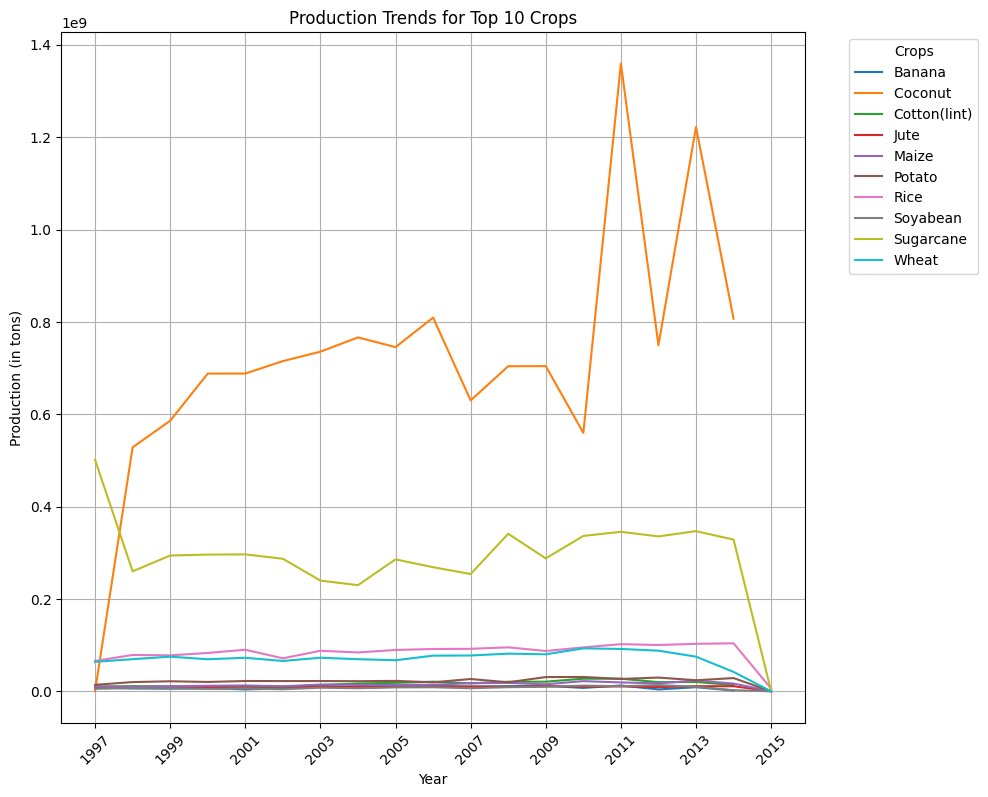

In [6]:
# Temporal trends for top crops :
# Filter for top 10 crops by production
top_crops = crop_df.groupby('Crop')['Production'].sum().nlargest(10).index
top_crops_data = crop_df[crop_df['Crop'].isin(top_crops)]

# scale the coconut production by 10 for better visualisation:
top_crops_data.loc[top_crops_data['Crop'].str.strip() == 'Coconut', 'Production'] = top_crops_data['Production'] / 10
grouped_data = top_crops_data.groupby(['Crop_Year', 'Crop'])['Production'].sum().unstack()
grouped_data.plot(figsize=(10, 8))
xlabel = 'Year'
ylabel = 'Production (in tons)'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend(title='Crops', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
#change x axis ticks to every 2 years
plt.xticks(grouped_data.index[::2], rotation=45)
plt.tight_layout()
plt.title('Production Trends for Top 10 Crops')

#Count total distinct crops in the dataset
total_crops = crop_df['Crop'].nunique()

# Print the list of top crops by production rank
print(f"Top 10 Crops by Production (Out of total {total_crops} distinct crops in dataset):")
for i, crop in enumerate(top_crops, start=1):
    print(f"{i}. {crop}")



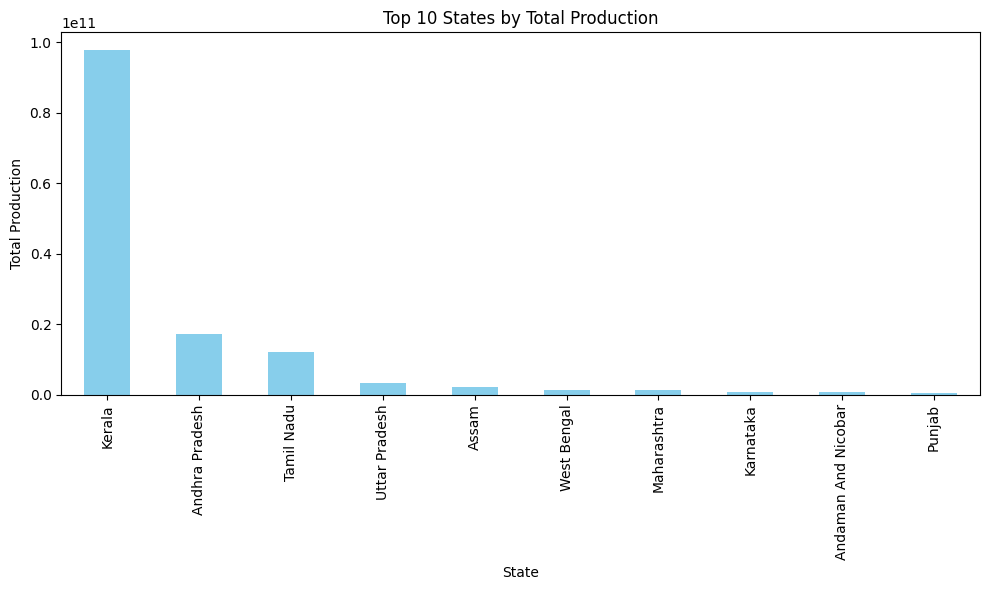

In [7]:
# Top production state as bar plot
top_production_state = crop_df.groupby('State_Name')['Production'].sum().nlargest(10)
top_production_state.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 States by Total Production')
plt.xlabel('State')
plt.ylabel('Total Production')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


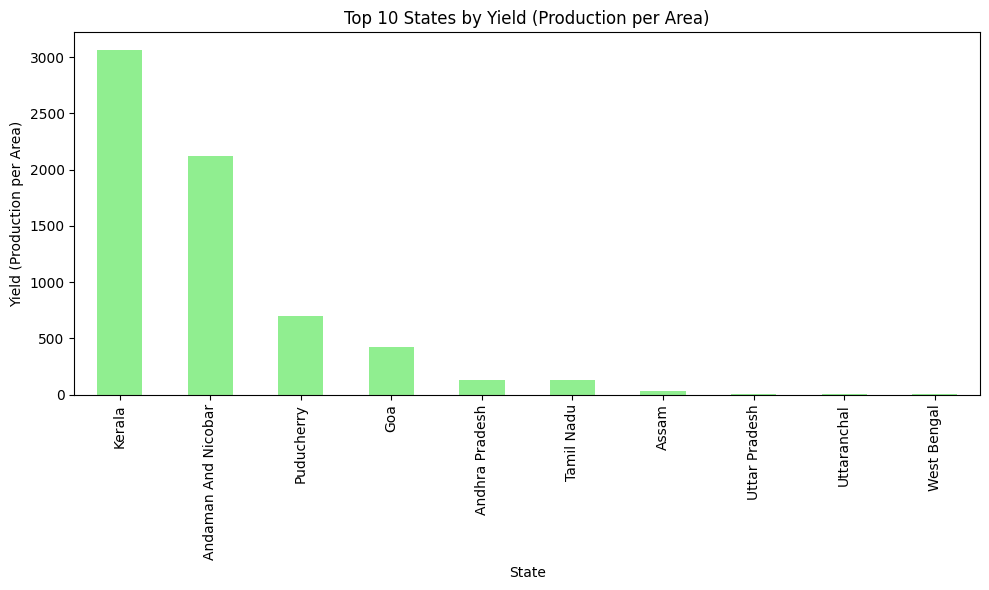

In [8]:
# Top yield state overall as bar plot

# Fill zero for the state district with missing production value:
crop_df['Production'] = crop_df['Production'].fillna(0)

top_yield_state = crop_df.groupby('State_Name')['Production'].sum() / crop_df.groupby('State_Name')['Area'].sum()
top_yield_state = top_yield_state.nlargest(10)
top_yield_state.plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Top 10 States by Yield (Production per Area)')
plt.xlabel('State')
plt.ylabel('Yield (Production per Area)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


C:\Users\Manish\AppData\Local\Temp\ipykernel_20424\1125318573.py:48: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_data)
d:\pywork\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 5 islands with ids: 0, 1, 246, 594, 595.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 246, ' is an island (no neighbors)')
('WARNING: ', 594, ' is an island (no neighbors)')
('WARNING: ', 595, ' is an island (no neighbors)')

Moran's I stats based on number of neighbors: 

Moran's I: 0.042984707998875736
P-value: 0.083403598983726

Hypothesis Testing:
Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.


Text(0.5, 1.0, 'Overall District Data Count distribution')

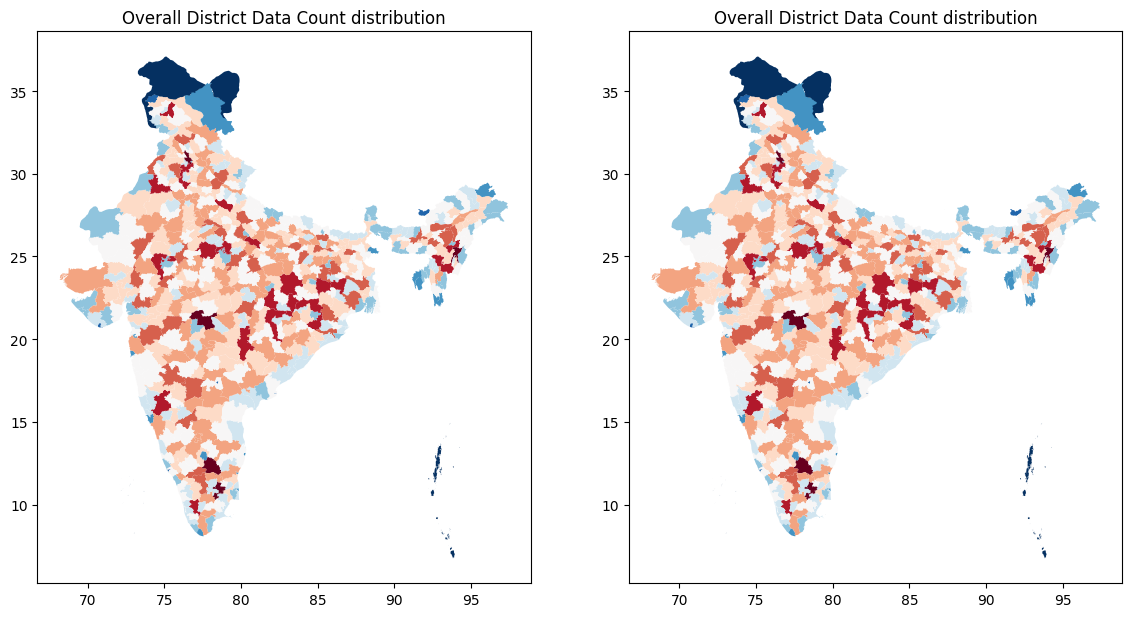

In [9]:
#ref:
# [1] https://darribas.org/gds_scipy16/ipynb_md/04_esda.html
# [2] https://sergerey.org/385f24/lectures/week06/spatial_weights.html#/imports
# [3] https://spatialanalysis.github.io/handsonspatialdata/contiguity-based-spatial-weights.html

# Aggregate data count/occurance by district (example for latest year)
latest_year = crop_df['Crop_Year'].max()
year = 1997

# District data count :
district_counts = crop_df.groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
district_counts.columns = ['State_Name','District_Name','Count']

# district_counts = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['District_Name'].value_counts().reset_index()
# district_counts.columns = ['State_Name','District_Name','Count']

# SHAP file data naming change to all captial letter
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file data naming change to all captial letter
district_counts['State_Name'] = district_counts['State_Name'].str.upper()
district_counts['District_Name'] = district_counts['District_Name'].str.strip().str.upper()


# Drop all data from structure
merged_data.iloc[:0]

# Merge production data with spatial data
merged_data = pd.merge(gdf,district_counts,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

#merged = gdf.merge(district_counts, how='left', left_on='DISTRICT', right_on='District_Name')

# Drop the districts with no count/data available:
# Define exception conditions 
# District to exclude from NaN filtering
exception_district = ['GILGIT', 'AKSAI CHIN']

# Filter: keep rows where 'count' is not NaN, or where 'state' is in exception_states
#merged_data = merged_data[(~merged_data['Count'].isna()) | (merged_data['District'].isin(exception_district))]


# Create spatial weights matrix (Contiguity-Based Spatial Weights) [3] 
# Contiguity means that two spatial units share a common border of non-zero length.
# In order to deal with potential inaccuracies in the polygon file (such as rounding errors),
# using the queen criterion is recommended in practice. Hence it is also the default for contiguity weights.
w = Queen.from_dataframe(merged_data)
Wmatrix, ids = w.full()
#print(Wmatrix)

n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has [2]

# Add new coloumn with number of neighbour count
merged_data['Neighbors_Count'] = n_neighbors


# Calculate Moran's I for spatial autocorrelation
moran = Moran(merged_data['Neighbors_Count'].fillna(0), w)

print(f"\nMoran's I stats based on number of neighbors: \n")
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_norm}")

#Evaluate Morans I stats for hypthesis testing:
# H0: There is no spatial autocorrelation in the data.
# H1: There is spatial autocorrelation in the data.
# If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is significant spatial autocorrelation in the data.
# If the p-value is greater than the significance level, we fail to reject the null hypothesis and conclude that there is no significant spatial autocorrelation in the data.
print(f"\nHypothesis Testing:")
if moran.p_norm < 0.05:
    print("Reject the null hypothesis: There is significant spatial autocorrelation in the data.")
else:
    print("Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.")


# Create a figure with two subplots in one row
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

# Plot each GeoDataFrame on its respective axis
merged_data.plot(ax=ax1, column='Neighbors_Count', legend=False,legend_kwds={'label': "District data Count"},cmap='RdBu_r', missing_kwds={'color': 'lightgrey'})
#overlay state boundaries
ax1.set_title('Overall District Data Count distribution')


merged_data.plot(ax=ax2, column='Neighbors_Count', legend=False,legend_kwds={'label': "District data Count"},cmap='RdBu_r', missing_kwds={'color': 'lightgrey'})
# merged_data['Neighbors_Count'] = pd.qcut(merged_data['Neighbors_Count'],q=14,duplicates='raise')
# merged_data.plot(ax=ax2, column='Neighbors_Count', legend=True,cmap='RdBu_r', missing_kwds={'color': 'lightgrey'})
#overlay state boundaries
#states_gdf.boundary.plot(ax=plt.gca(), color='green', linewidth=0.5)
ax2.set_title('Overall District Data Count distribution')

# plt.tight_layout()
# plt.show()

#YlGn
#RdYlGn_r

      

C:\Users\Manish\AppData\Local\Temp\ipykernel_20424\3374401831.py:35: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(merged_data)
d:\pywork\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 5 islands with ids: 0, 1, 246, 594, 595.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 246, ' is an island (no neighbors)')
('WARNING: ', 594, ' is an island (no neighbors)')
('WARNING: ', 595, ' is an island (no neighbors)')


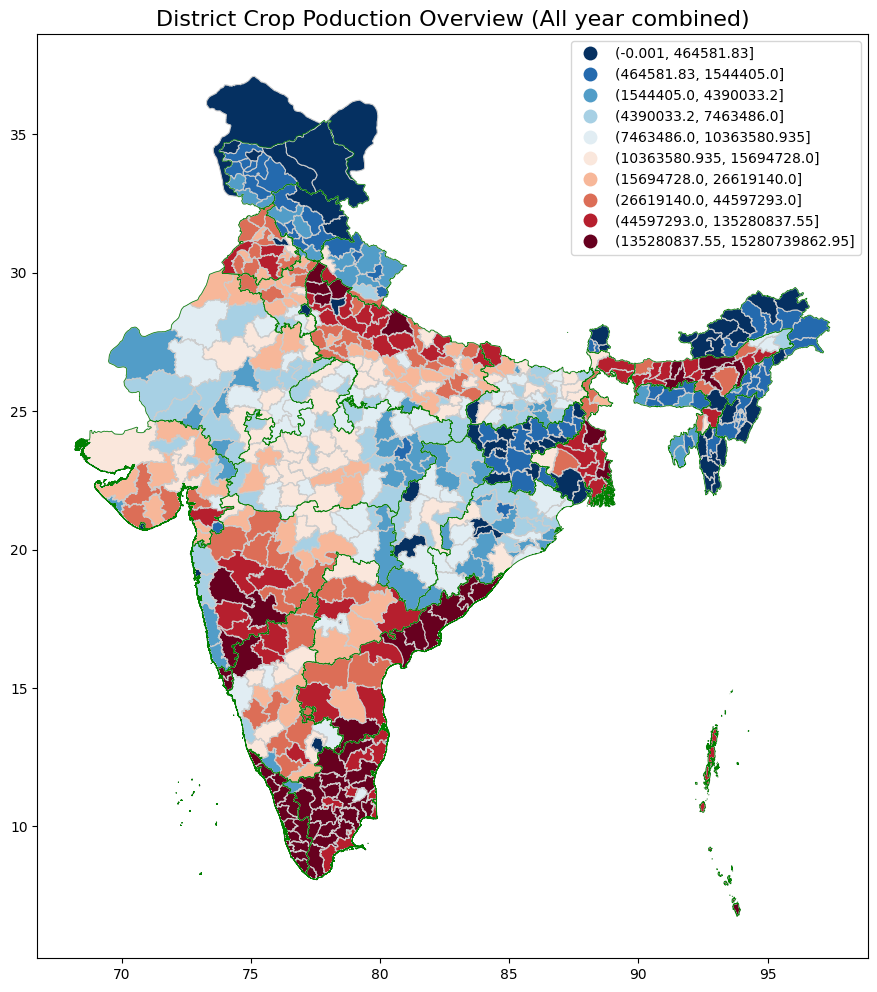

In [10]:
# Creating charts for Total production 
# Aggregate data count/occurance by district (example for latest year)
latest_year = crop_df['Crop_Year'].max()
year = 2009

# Mean over all years and seasons production for each district    
District_Production = crop_df.groupby(['State_Name','District_Name'])['Production'].sum().reset_index()
District_Production.columns = ['State_Name','District_Name','Production']

# Mean of specific year and seasons production for each district:
# District_Production = crop_df[crop_df['Crop_Year'] == year].groupby(['State_Name','District_Name'])['Production'].mean().reset_index()
# District_Production.columns = ['State_Name','District_Name','Production']

# SHAP file State and district naming change to all captial letter:
gdf["District"] = gdf["District"].str.strip().str.upper()
gdf["STATE"] = gdf["STATE"].str.strip().str.upper() 

# CSV file State and district naming change to all captial letter:
District_Production['State_Name'] = District_Production['State_Name'].str.upper()
District_Production['District_Name'] = District_Production['District_Name'].str.strip().str.upper()

merged_data = pd.merge(gdf,District_Production,how='left',left_on=['STATE','District'],right_on=['State_Name','District_Name'])
merged_data.drop(['State_Name','District_Name'],inplace=True,axis=1)

# Check District with no data/naming match (only for debug mismatched district):
#unmerge_struct = merged_data[merged_data['Production'].isna()]

# Fill zero for districts with no data available:
merged_data['Production'] = merged_data['Production'].fillna(0)

# Create spatial weights matrix (Contiguity-Based Spatial Weights)
# Contiguity means that two spatial units share a common border of non-zero length.
# In order to deal with potential inaccuracies in the polygon file (such as rounding errors),
# using the queen criterion is recommended in practice. Hence it is also the default for contiguity weights.
w = Queen.from_dataframe(merged_data)
Wmatrix, ids = w.full()
#print(Wmatrix)

n_neighbors = Wmatrix.sum(axis=1) # how many neighbors each region has [2]

# Add new coloumn with number of neighbour count
merged_data['Neighbors_Count'] = n_neighbors


# Calculate Moran's I for spatial autocorrelation
moran = Moran(merged_data['Production'].fillna(0), w)

merged_data_Copy = merged_data.copy()
# Discretize Production into equal-sized bin based on sample quantiles
#merged_data['Production'] = pd.qcut(merged_data.Production,q=3,labels=["High", "Medium", "Low"])
merged_data_Copy['Production'] = pd.qcut(merged_data_Copy['Production'],q=10,duplicates='drop')

plt.figure(figsize=(12,12))

merged_data_Copy.plot(column='Production',cmap='RdBu_r', missing_kwds={'color': 'lightgrey'},linewidth=0.8, ax=plt.gca(), edgecolor='0.8',legend=True)
plt.title('District Crop Poduction Overview (All year combined)',fontsize=16)

#overlay state boundaries
states_gdf.boundary.plot(ax=plt.gca(), color='green', linewidth=0.5)

plt.show()


Hypothesis Testing:
Reject the null hypothesis: There is significant spatial autocorrelation in the data.
Moran's I: 0.5206586218929101
P-value: 3.8264640999222985e-91


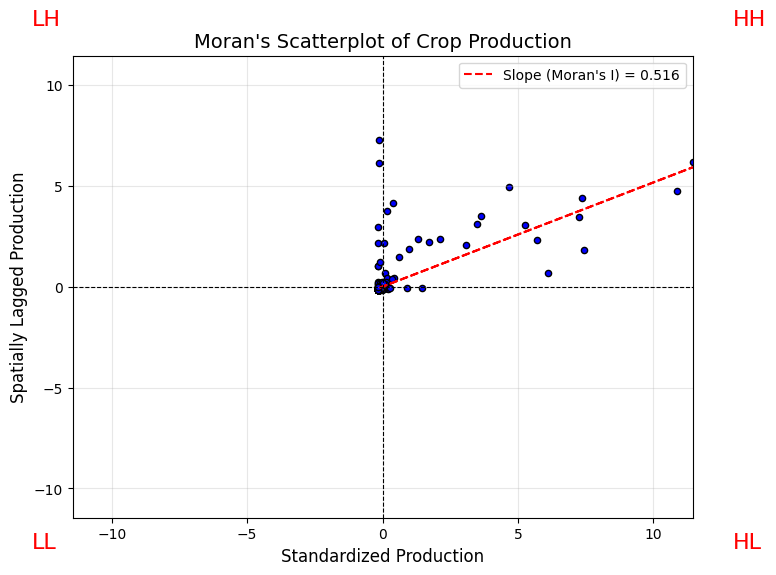

In [11]:
# Spatial lag vs production using contiguity weigth matrix (Queen)
print(f"\nHypothesis Testing:")
if moran.p_norm < 0.05:
    print("Reject the null hypothesis: There is significant spatial autocorrelation in the data.")
else:
    print("Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.")

print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_norm}")
# Fill missing values in 'Production' with 0
# spatial_lag = lag_spatial(w, merged_data['Production'])

# Ensure 'Production' column has no missing values
#production = merged_data['Production'].fillna(0)

# Drop the rows with NaN values in 'Production' column
production = merged_data['Production'].dropna()

# Standardize the 'Production' column
z = (production - production.mean()) / production.std()

# Calculate the spatial lag of z
# w -> Queen Contiguity weights matrix
lag_z = lag_spatial(w, z)

# Ensure z and lag_z have the same length
if len(z) != len(lag_z):
    raise ValueError("Mismatch in dimensions between z and lag_z.")

# Calculate regression slope (Moran's I)
b, a = np.polyfit(z, lag_z, 1)

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(z, lag_z, c='blue', edgecolor='k', s=20)
plt.plot(z, a + b*z, 'r--', label=f'Slope (Moran\'s I) = {b:.3f}')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.axvline(0, color='k', linestyle='--', linewidth=0.8)

#xrange should be max of z and lag_z
xrange = max(z.max(), lag_z.max())
plt.xlim(-xrange, xrange)
plt.ylim(-xrange, xrange)

# Add quadrant labels
plt.text(1.5+xrange, 1.5+xrange, 'HH', fontsize=16, color='red')
plt.text(-1.5-xrange, 1.5+xrange, 'LH', fontsize=16, color='red')
plt.text(-1.5-xrange, -1.5-xrange, 'LL', fontsize=16, color='red')
plt.text(1.5+xrange, -1.5-xrange, 'HL', fontsize=16, color='red')



plt.xlabel('Standardized Production', fontsize=12)
plt.ylabel('Spatially Lagged Production', fontsize=12)
plt.title("Moran's Scatterplot of Crop Production", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Types of season: ['Kharif' 'Whole Year' 'Autumn' 'Rabi' 'Summer' 'Winter']
Season: Whole Year, Crop: Coconut , Production: 1651187.7874020578
Season: Kharif, Crop: Sugarcane, Production: 1531013.3605694566
Season: Rabi, Crop: Oilseeds total, Production: 1334167.2413793104
Season: Winter, Crop: Rice, Production: 169285.48600266193


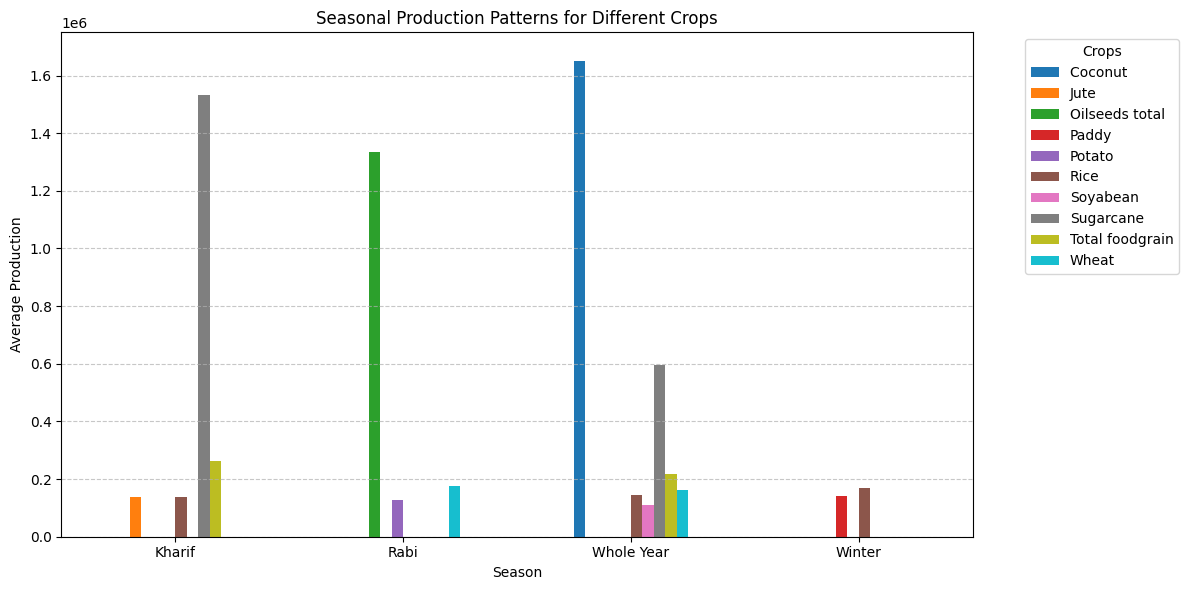

In [12]:
# Seasonal production patterns
# ['State_Name', 'District_Name', 'Crop_Year', 'Season', 'Crop', 'Area', 'Production']
# Strip any extra whitespace from the 'Season' column to ensure consistency
crop_df['Season'] = crop_df['Season'].str.strip()

# Get unique seasons
season = crop_df['Season'].unique()
print(f'Types of season: {season}')

# Filter for top 10 crops by production
seasonal = crop_df.groupby(['Season','Crop'])['Production'].mean().nlargest(15).reset_index()

#scale the coconut production by 10 for better visualisation:
seasonal.loc[seasonal['Crop'].str.strip() == 'Coconut', 'Production'] = seasonal['Production'] / 40
#seasonal.loc[seasonal['Crop'].str.strip() == 'Oilseeds total', 'Production'] = seasonal['Production'] / 10
#seasonal.loc[seasonal['Crop'].str.strip() == 'Sugarcane', 'Production'] = seasonal['Production'] / 10

#Print the crop with maximum production in each season:
for s in seasonal['Season'].unique():
    max_crop = seasonal[seasonal['Season'] == s].sort_values(by='Production', ascending=False).iloc[0]
    print(f"Season: {s}, Crop: {max_crop['Crop']}, Production: {max_crop['Production']}")

# plot the seasonal production patterns
seasonal_pivot = seasonal.pivot(index='Season', columns='Crop', values='Production')

seasonal_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Seasonal Production Patterns for Different Crops')
plt.xlabel('Season')
plt.ylabel('Average Production')
plt.xticks(rotation=0)
# limit the yaxis to 0-1000000 for better visualisation
plt.ylim(0, 1750000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Crops', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



C:\Users\Manish\AppData\Local\Temp\ipykernel_20424\4259532816.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts_centroid['centroid'] = districts_centroid.geometry.centroid
d:\pywork\.venv\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


1: ANDAMAN ISLANDS (ANDAMAN AND NICOBAR)
2: NICOBAR ISLANDS (ANDAMAN AND NICOBAR)
3: ANANTAPUR (ANDHRA PRADESH)
4: CHITTOOR (ANDHRA PRADESH)
5: CUDDAPAH (ANDHRA PRADESH)
6: EAST GODAVARI (ANDHRA PRADESH)
7: GUNTUR (ANDHRA PRADESH)
8: KRISHNA (ANDHRA PRADESH)
9: KURNOOL (ANDHRA PRADESH)
10: NELLORE (ANDHRA PRADESH)
11: PRAKASAM (ANDHRA PRADESH)
12: SRIKAKULAM (ANDHRA PRADESH)
13: VISHAKHAPATNAM (ANDHRA PRADESH)
14: VIZIANAGARAM (ANDHRA PRADESH)
15: WEST GODAVARI (ANDHRA PRADESH)
16: CHANGLANG (ARUNACHAL PRADESH)
17: EAST KAMENG (ARUNACHAL PRADESH)
18: EAST SIANG (ARUNACHAL PRADESH)
19: KURUNG KUMEY (ARUNACHAL PRADESH)
20: LOHIT (ARUNACHAL PRADESH)


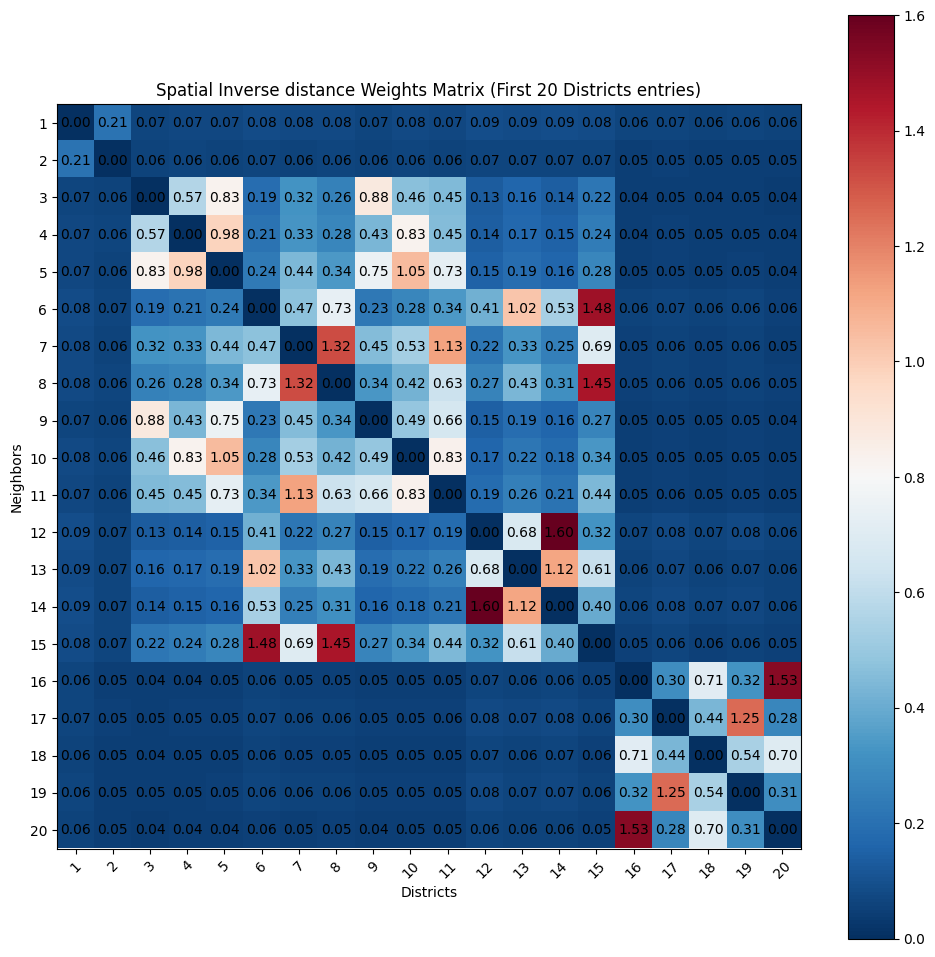

In [13]:
# Inverse Distance Weight Matrix based Moran's I:


districts_centroid = merged_data #.groupby(['STATE', 'District']).geometry.first().reset_index()

# Calculate centroids
districts_centroid['centroid'] = districts_centroid.geometry.centroid

# Extract coordinates
coords = [(point.x, point.y) for point in districts_centroid['centroid']]

# Create a spatial weights matrix using DistanceBand (distancein meters)
# The threshold in DistanceBand refers to the critical distance (also called the distance band or cutoff distance)
# used to define which observations are considered neighbors in a spatial weights matrix
w2 = DistanceBand(coords, threshold=100000, binary=False, silence_warnings=True)

# Inverse Distanace Weight Matrix:
Wmatrix, ids = w2.full()
# Below Matrix plot showing how inverse matrix usefull for spatial autocorrelation by weighting neighboring observations 
# The inverse distance weight matrix W assigns higher weights to closer neighbors and lower weights to distant ones

plt.figure(figsize=(12, 12))

No_of_entries = 20
plt.imshow(Wmatrix[:No_of_entries, :No_of_entries], cmap='RdBu_r')
plt.title(f'Spatial Inverse distance Weights Matrix (First {No_of_entries} Districts entries)')
plt.xlabel('Districts')
plt.ylabel('Neighbors')
# plot Wmatrix value in each box as well
for i in range(No_of_entries):
    for j in range(No_of_entries):
        plt.text(j, i, f"{Wmatrix[i, j]:.2f}", ha='center', va='center', color='black')
# print first 10 district name from districts_centroid with indexing:
for i, district in enumerate(districts_centroid['District'].unique()[:No_of_entries], start=1):
    state = districts_centroid[districts_centroid['District'] == district]['STATE'].iloc[0]
    print(f"{i}: {district} ({state})")

plt.xticks(range(No_of_entries), districts_centroid['District'].unique()[:No_of_entries], rotation=45)
plt.xticks(range(No_of_entries), range(1, No_of_entries+1))
plt.yticks(range(No_of_entries), range(1, No_of_entries+1))
plt.colorbar()
plt.show()




Hypothesis Testing:
Reject the null hypothesis: There is significant spatial autocorrelation in the data.
Moran's I: 0.10807553417549476
P-value: 3.1217921198689403e-278


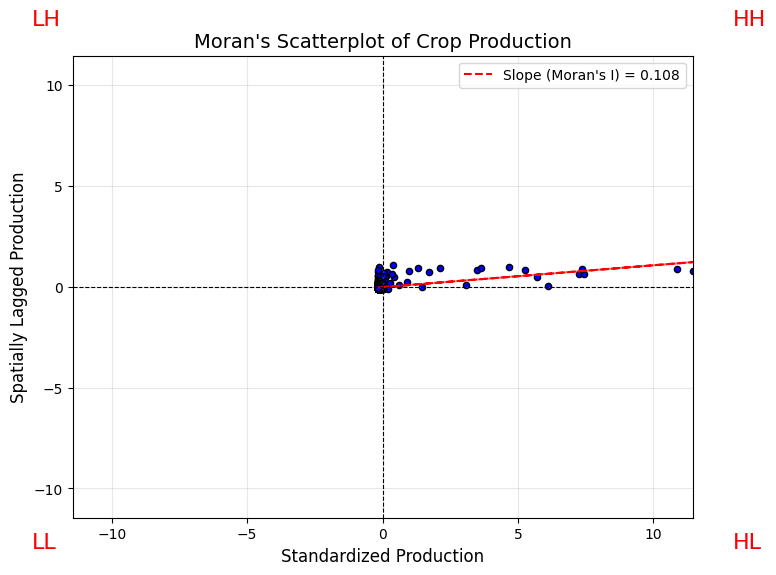

In [ ]:
# Calculate Moran's I for spatial autocorrelation using inverse distance weight matrix
moran2 = Moran(districts_centroid['Production'].fillna(0), w2)

print(f"\nHypothesis Testing:")
if moran2.p_norm < 0.05:
    print("Reject the null hypothesis: There is significant spatial autocorrelation in the data.")
else:
    print("Fail to reject the null hypothesis: There is no significant spatial autocorrelation in the data.")

print(f"Moran's I: {moran2.I}")
print(f"P-value: {moran2.p_norm}")

# # Spatial lag vs production :
# spatial_lag = lag_spatial(w, districts_centroid['Production'].fillna(0))
# plt.scatter(districts_centroid['Production'], spatial_lag)

# plt.xlabel("Production")
# plt.ylabel("Spatially Lagged Production")
# plt.title("Moran Scatterplot")

# Ensure 'Production' column has no missing values
#production2 = districts_centroid['Production'].fillna(0)
production2 = districts_centroid['Production'].dropna()

# Standardize value of 'Production' column
z2 = (production2 - production2.mean()) / production2.std()

# Calculate the spatial lag of z (weighted average of neighbors)
# w2 -> Calculated weights using inverse distance for continuous relationships
lag_z2 = lag_spatial(w2, z2)

# Ensure z and lag_z have the same length
if len(z) != len(lag_z2):
    raise ValueError("Mismatch in dimensions between z and lag_z.")

    

# Calculate regression slope (Moran's I)
b2, a2 = np.polyfit(z2, lag_z2, 1)

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(z2, lag_z2, c='blue', edgecolor='k', s=20)
plt.plot(z2, a2 + b2*z2, 'r--', label=f'Slope (Moran\'s I) = {b2:.3f}')

#xrange should be max of z and lag_z
xrange = max(z2.max(), lag_z2.max())
plt.xlim(-xrange, xrange)
plt.ylim(-xrange, xrange)

# Add quadrant labels
plt.text( 1.5+xrange,  1.5+xrange, 'HH', fontsize=16, color='red')
plt.text(-1.5-xrange,  1.5+xrange, 'LH', fontsize=16, color='red')
plt.text(-1.5-xrange, -1.5-xrange, 'LL', fontsize=16, color='red')
plt.text( 1.5+xrange, -1.5-xrange, 'HL', fontsize=16, color='red')


plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel('Standardized Production', fontsize=12)
plt.ylabel('Spatially Lagged Production', fontsize=12)
plt.title("Moran's Scatterplot of Crop Production", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



#### Each quadrant represents:
> - HH: High value, high spatial lag (upper right)
- LL: Low value, low spatial lag (lower left)
- LH: Low value, high spatial lag (upper left)
- HL: High value, low spatial lag (lower right)

> From the scatter plot we observed High values surrounded by high values (positive spatial autocorrelation). Strong clustering of above-average values.
> Another observation is the lower presence in other Quadrants, No significant LL (low-low), LH (low-high), or HL (high-low) clusters. Suggests low values are dispersed or not statistically significant.

> - Positive slope (I > 0) indicates spatial clustering
- Negative slope (I < 0) suggests spatial dispersion
- Slope = 0 implies random spatial pattern

C:\Users\Manish\AppData\Local\Temp\ipykernel_20424\2322565949.py:30: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_lisa = Queen.from_dataframe(State_local)
d:\pywork\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 5 islands with ids: 0, 1, 246, 594, 595.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 246, ' is an island (no neighbors)')
('WARNING: ', 594, ' is an island (no neighbors)')
('WARNING: ', 595, ' is an island (no neighbors)')


d:\pywork\.venv\Lib\site-packages\esda\moran.py:1350: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


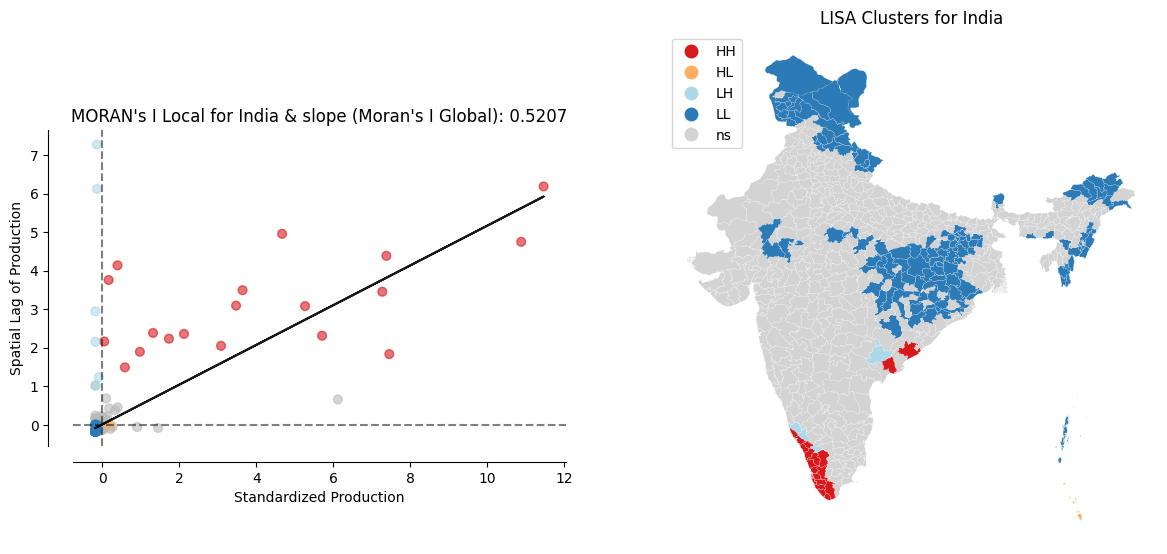

In [15]:
# Calculate Local Moran's I for spatial autocorrelation (LISA):
# Local Indicators of Spatial Association (LISA) are used to identify clusters of similar values in a spatial dataset.
# They help to identify local patterns of spatial association, which can be useful for understanding the spatial structure of the data.
# LISA is a local version of Moran's I, which measures spatial autocorrelation at the level of individual observations.
# It identifies clusters of similar values (high-high or low-low) and outliers (high-low or low-high) in the data.
# LISA is useful for identifying local patterns of spatial association, which can be useful for understanding the spatial structure of the data.
# [1] https://geographicdata.science/book/notebooks/07_local_autocorrelation.html
# [2] https://geodacenter.github.io/workshops/Spatial_Analysis/Spatial_Autocorrelation.html
# [3] https://walker-data.com/posts/esda-with-python/



from esda.moran import Moran_Local
import splot.esda as splot

All_states = 1  # Set 1 for All states


if All_states >= 1:
    # Assume All states and their districts :
    State_local = merged_data.copy()
    target_state = 'India'
else:
    # Select Particular state to Analyse:
    target_state =  'UTTAR PRADESH' #"ANDHRA PRADESH" #'TAMIL NADU' #'UTTAR PRADESH'
    State_local = merged_data[merged_data["STATE"] == target_state]


# Generate Queen contiguity weights for the state
w_lisa = Queen.from_dataframe(State_local)

# Ensure all districts have at least one neighbor
w_lisa.transform = 'B'  # Binary weights

# State's Moran's Global scatter Plot
moran_glo = Moran(State_local['Production'], w_lisa,  permutations=999)
# State's Moran's local cluster
moran_loc = Moran_Local(State_local['Production'], w_lisa,  permutations=999)


# Parameter for Local I map plot:
# moran_loc.Is: Array of Local Moran's I values for each district.
# moran_loc.p_sim: P-values from permutation tests.
# moran_loc.q: Quadrant codes for cluster types (HH, LL, etc.).
    
results = gpd.GeoDataFrame({
    "LISA_Cluster": moran_loc.q,
    "p-value": moran_loc.p_sim,
    "Local_I": moran_loc.Is,
    "geometry": State_local.geometry,
    "District": State_local["District"]
})

#if All_states == 0:  # State's Moran Global scatter Plot

# Create plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
    
# Moran locAL scatterplot with spatial lag
moran_scatterplot(moran_loc, p=0.05,aspect_equal=True, ax=ax1)
ax1.set_xlabel("Standardized Production")
ax1.set_ylabel("Spatial Lag of Production")
ax1.title.set_text(f'MORAN\'s I Local for {target_state} & slope (Moran\'s I Global): {moran_glo.I:.4f}')

#plt.show()

# Moran scatterplot Global with spatial lag
# moran_scatterplot(moran_glo, p=0.05,aspect_equal=True, ax=ax2)
# ax2.set_xlabel("Standardized Production")
# ax2.set_ylabel("Spatial Lag of Production")
# ax2.title.set_text(f'MORANs I scatter plot for {target_state}')
# 

lisa_cluster(moran_loc, results, p=0.05, ax=ax2,legend_kwds={'loc': 'upper left'} )
ax2.title.set_text(f'LISA Clusters for {target_state}')



    
# 🔴 HH: High-High
# 🔵 LL: Low-Low
# 🟢 HL/LH: Outliers
#  Rest All Non Significant (ns)

d:\pywork\.venv\Lib\site-packages\scipy\sparse\_data.py:128: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


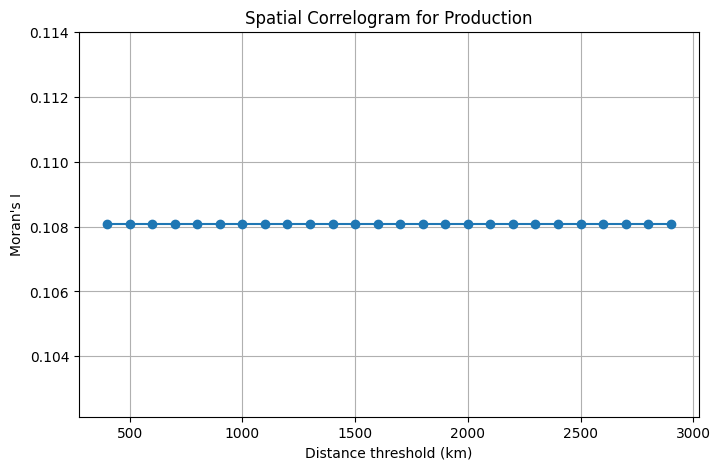

In [16]:
# Correlogram with moving Moran's I

from libpysal.weights import DistanceBand


# Define distance thresholds (in meters, adjust as needed)
# thresholds = np.arange(10000, 100001, 10000)  # 10km to 100km in 10km steps
thresholds = np.arange(400000, 3000000, 100000)  # 10km to 100km in 10km steps

morans_i = []

for thresh in thresholds:

    # w_corr = Queen.from_dataframe(State_local,  silence_warnings=True)
    # w_corr.transform = 'B'  # Binary weights
    # mi = Moran(State_local['Production'], w_corr)
    # morans_i.append(mi.I)

    w_corr = DistanceBand(coords, threshold=thresh, binary=False, silence_warnings=True)
    mi = Moran(State_local['Production'], w_corr)
    morans_i.append(mi.I)

# Plot correlogram
plt.figure(figsize=(8,5))
plt.plot(thresholds/1000, morans_i, marker='o')

plt.xlabel('Distance threshold (km)')
plt.ylabel("Moran's I")
plt.title("Spatial Correlogram for Production")
plt.grid(True)
plt.show()



Geary's C: 0.4862
Expected C under randomness: 1.0000
p-value (simulated): 0.0010


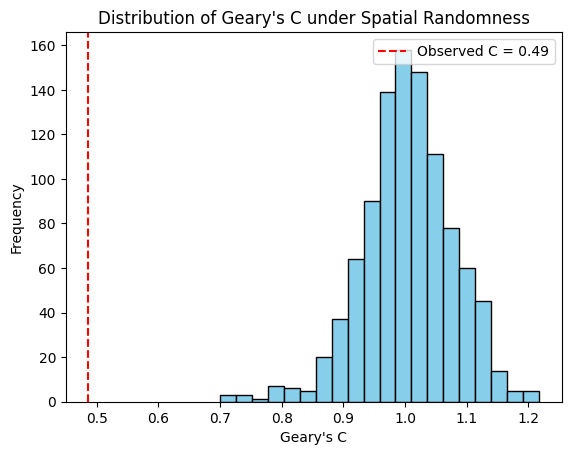

In [17]:
from esda.geary import Geary

# Compute Geary's C with 999 permutations for significance testing
geary = Geary(State_local['Production'], w, permutations=999)

# Results
print(f"Geary's C: {geary.C:.4f}")
print(f"Expected C under randomness: {geary.EC:.4f}")
print(f"p-value (simulated): {geary.p_sim:.4f}")

# Geary's C:

# C<1: Positive spatial autocorrelation (similar values cluster).
# C>1: Negative spatial autocorrelation (dissimilar values cluster).
# C≈1: No spatial pattern (random distribution).

# p-value: A value ≤ 0.05 indicates statistical significance.

plt.hist(geary.sim, bins=20, color='skyblue', edgecolor='k')
plt.axvline(geary.C, color='red', linestyle='--', label=f'Observed C = {geary.C:.2f}')
plt.xlabel("Geary's C")
plt.ylabel("Frequency")
plt.title("Distribution of Geary's C under Spatial Randomness")
plt.legend()
plt.show()


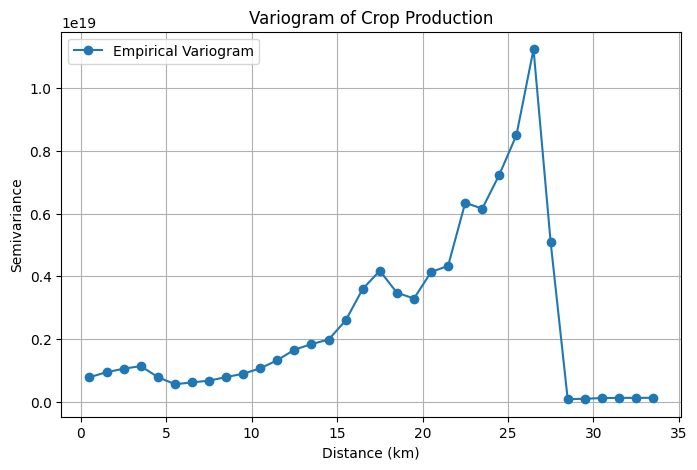

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 2.40577549734216e+17
Nugget: 3.3356972091509536e+16 



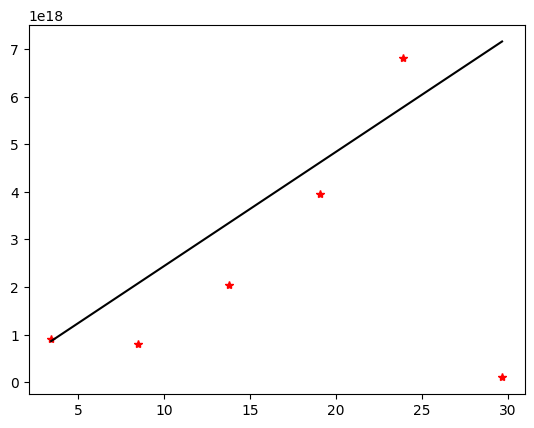

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



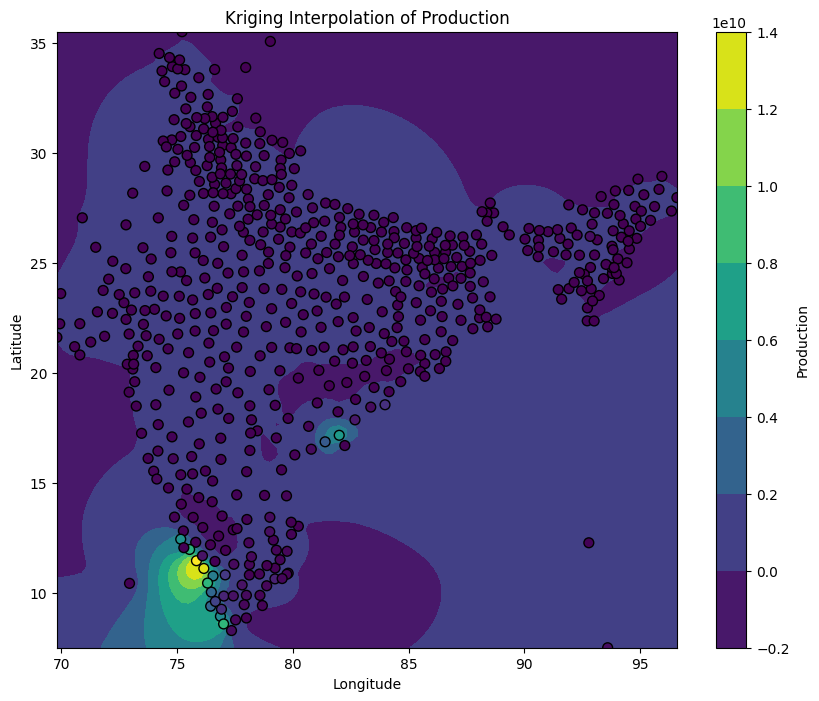

In [18]:
# do pip install pykrige before this part
from pykrige.ok import OrdinaryKriging
from pykrige.variogram_models import spherical_variogram_model
from sklearn.metrics import pairwise_distances

# Extract coordinates and production values
coords = np.array([(point.x, point.y) for point in merged_data['centroid']])
values = merged_data['Production'].fillna(0).values

# for variogram
# Compute pairwise distances
dists = pairwise_distances(coords)

# Compute empirical semivariances
semivariances = []
lag_distances = []
step = 1  # km or appropriate unit
max_dist = 50

for h in np.arange(0, max_dist, step):
    mask = (dists >= h) & (dists < h + step)
    if np.any(mask):
        semivariance = 0.5 * np.mean((values[:, None] - values[None, :])[mask]**2)
        semivariances.append(semivariance)
        lag_distances.append(h + step / 2)

# Plot the empirical variogram
plt.figure(figsize=(8, 5))
plt.plot(lag_distances, semivariances, 'o-', label='Empirical Variogram')
plt.xlabel('Distance (km)')
plt.ylabel('Semivariance')
plt.title('Variogram of Crop Production')
plt.grid(True)
plt.legend()
plt.show()


# Create a grid for kriging
grid_x = np.linspace(coords[:, 0].min(), coords[:, 0].max(), 100)
grid_y = np.linspace(coords[:, 1].min(), coords[:, 1].max(), 100)

# Perform ordinary kriging
OK = OrdinaryKriging(
    coords[:, 0], coords[:, 1], values,
    variogram_model='linear',  # You can also use 'exponential', 'gaussian', etc.
    verbose=True,
    enable_plotting=True
)

# Interpolate the grid
z, ss = OK.execute('grid', grid_x, grid_y)

# Plot the kriged result
plt.figure(figsize=(10, 8))
plt.contourf(grid_x, grid_y, z, cmap='viridis')
plt.colorbar(label='Production')
plt.scatter(coords[:, 0], coords[:, 1], c=values, cmap='viridis', edgecolor='k', s=50)
plt.title('Kriging Interpolation of Production')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

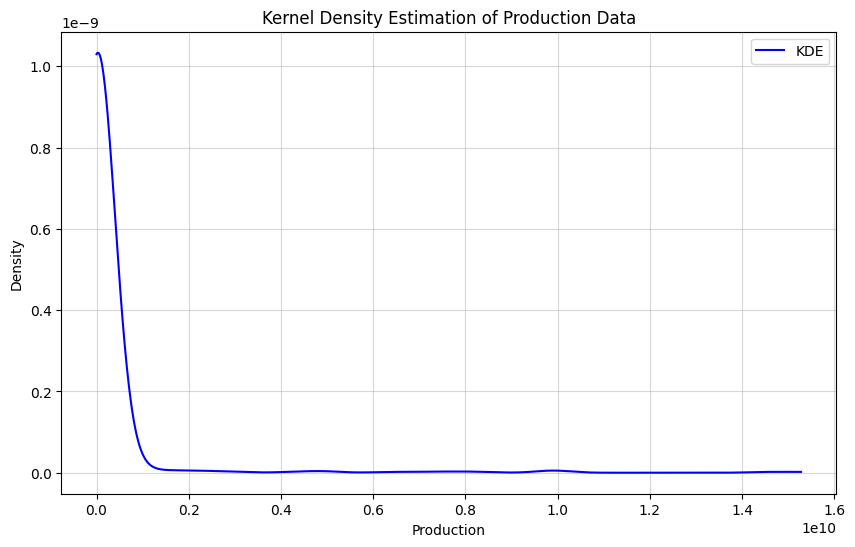

In [19]:
from scipy.stats import gaussian_kde
import numpy as np

import matplotlib.pyplot as plt

# Perform KDE on the production data
production_values = production.values  # Extract values from the Series
kde = gaussian_kde(production_values)

# Generate a range of values for plotting the KDE
x_range = np.linspace(production_values.min(), production_values.max(), 1000)
kde_values = kde(x_range)

# Plot the KDE
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values, label='KDE', color='blue')
plt.title('Kernel Density Estimation of Production Data')
plt.xlabel('Production')
plt.ylabel('Density')
plt.grid(alpha=0.5)
plt.legend()
plt.show()